In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [2]:
# standardization code
standardizator = transforms.Compose([
                    transforms.Grayscale(),
                    transforms.ToTensor(),
#                     transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels이나 실제론 gray scale
#                                          std=(0.5, 0.5, 0.5))
])  

# MNIST dataset
train_data = datasets.MNIST(root='./data/', train=True, transform=standardizator, download=True)
test_data  = datasets.MNIST(root='./data/', train=False, transform=standardizator, download=True)


batch_size = 128
train_data_loader = DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = DataLoader(test_data, batch_size, shuffle=True)

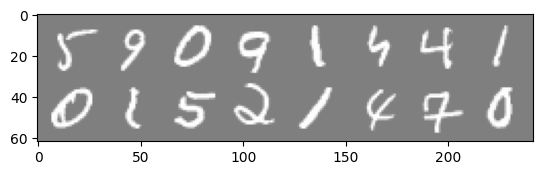

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])
# example_mini_batch_img.shape

In [66]:
G = nn.Sequential(
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512,28*28)
).to(device)

In [77]:
D = nn.Sequential(
    nn.Linear(28*28, 512),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 1),
    nn.Tanh()
).to(device)

In [78]:
input_data = torch.randn(batch_size, 128, device=device)
G(input_data).shape

torch.Size([128, 784])

In [79]:
D(G(input_data)).shape

torch.Size([128, 1])

In [80]:
criterion = nn.BCELoss()

optimizer_g = optim.Adam(G.parameters(), lr = 1e-04)
optimizer_d = optim.Adam(D.parameters(), lr = 1e-04)

(epoch 0/256) p_real : -0.0003, p_fake : 0.0047


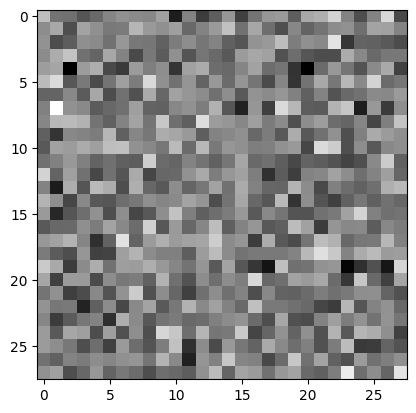

(epoch 16/256) p_real : 1.0000, p_fake : -1.0000


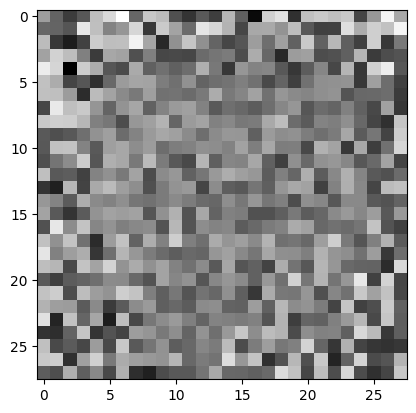

(epoch 32/256) p_real : 1.0000, p_fake : -1.0000


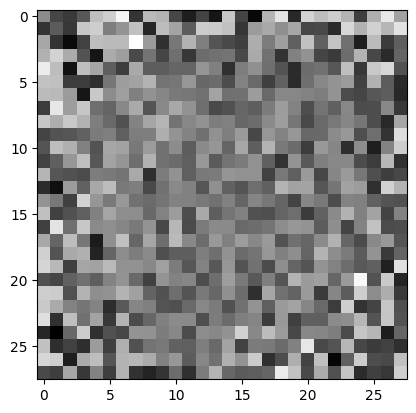

(epoch 48/256) p_real : 1.0000, p_fake : -1.0000


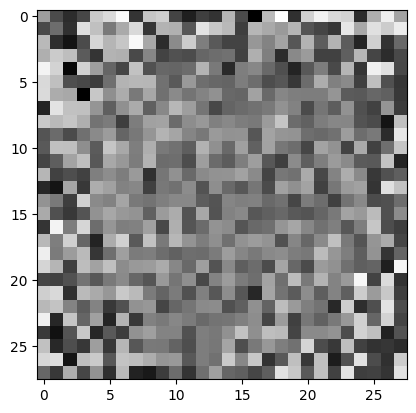


KeyboardInterrupt



In [81]:
epochs = 256

p_real_trace = []
p_fake_trace = []

for epoch in range(epochs):
    G.train()
    D.train()
    for step, (img_batch, label_batch) in enumerate(train_data_loader):
        img_batch, label_batch = img_batch.to(device), label_batch.to(device)
        optimizer_d.zero_grad()
        
        p_real = D(img_batch.view(-1,28*28))
        z = torch.randn(img_batch.shape[0], 128, device=device)
        p_fake = D(G(z))
        
        loss_real = -1 * torch.log(p_real)
        loss_fake = -1 * torch.log(1. - p_fake)
        loss_d = (loss_real + loss_fake).mean()
        p_real_trace.append(loss_d.item())
        loss_d.backward()
        optimizer_d.step()
        
        optimizer_g.zero_grad()
        z = torch.randn(img_batch.shape[0], 128, device=device)
        p_fake = D(G(z))
        
        loss_g = -1*torch.log(p_fake).mean()
        p_fake_trace.append(p_fake.item())
        loss_g.backward()
        optimizer_g.step()
        
        if epoch%15==0 and step ==0:
            p_real, p_fake = 0.,0.
            G.eval()
            D.eval()
            
            for step , (img_batch, label_batch) in enumerate(test_data_loader):
                img_batch, label_batch = img_batch.to(device), label_batch.to(device)
                
                with torch.autograd.no_grad():
                    p_real += (torch.sum(D(img_batch.view(-1,28*28))).item())/10000.
                    z = torch.randn(img_batch.shape[0], 128, device=device)
                    p_fake += (torch.sum(D(G(z))).item())/10000.
            
                    
#         if epoch&16==0 and step == 0 :
            print(f"(epoch {epoch}/{epochs}) p_real : {p_real:.4f}, p_fake : {p_fake:.4f}")
            imshow(G(torch.randn(1, 128, device=device)).view(-1,1,28,28).cpu().detach())

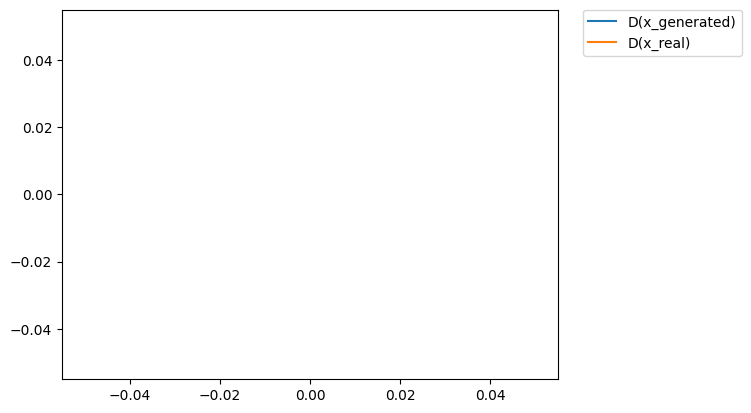

In [82]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

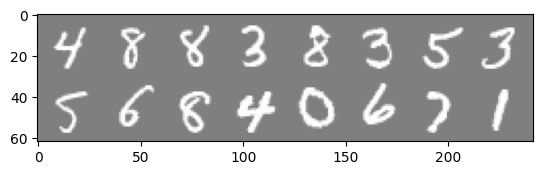

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


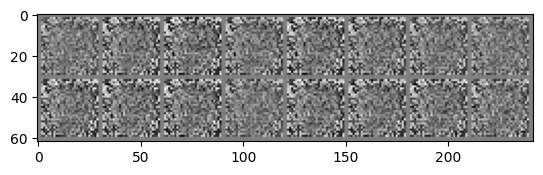

In [83]:
vis_loader = torch.utils.data.DataLoader(test_data, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

z = torch.randn(16,128, device=device)
imshow_grid(G(z).view(-1, 1, 28, 28))

# Kobert

In [1]:
from konlpy.tag import Kkma

In [2]:
kkma = Kkma()

In [3]:
sentence = "나는 밥을 먹었다. 너는 어때? 인공지능 시험을 잘보고 싶었는데, 생각보다 어렵네"

In [8]:
print(kkma.nouns(sentence))

['나', '밥', '때', '인공', '인공지능', '지능', '시험', '생각']


In [6]:
print(kkma.pos(sentence))

[('나', 'NP'), ('는', 'JX'), ('밥', 'NNG'), ('을', 'JKO'), ('먹', 'VV'), ('었', 'EPT'), ('다', 'EFN'), ('.', 'SF'), ('느', 'VV'), ('어', 'ECS'), ('는', 'JX'), ('어', 'VV'), ('어', 'ECS'), ('때', 'NNG'), ('?', 'SF'), ('인공지능', 'NNG'), ('시험', 'NNG'), ('을', 'JKO'), ('잘', 'MAG'), ('보', 'VV'), ('고', 'ECE'), ('싶', 'VXA'), ('었', 'EPT'), ('는데', 'ECD'), (',', 'SP'), ('생각', 'NNG'), ('보다', 'JKM'), ('어렵', 'VA'), ('네', 'EFN')]


In [9]:
from konlpy.tag import Okt
okt = Okt()

In [10]:
print(okt.morphs(sentence))

['나', '는', '밥', '을', '먹었다', '.', '너', '는', '어때', '?', '인공', '지능', '시험', '을', '잘', '보고', '싶었는데', ',', '생각', '보다', '어렵네']


In [11]:
print(okt.nouns(sentence))

['나', '밥', '너', '인공', '지능', '시험', '생각']


In [12]:
print(okt.phrases(sentence))

['인공지능', '인공지능 시험', '생각', '인공', '지능', '시험']


In [14]:
import mxnet as mx
from mxnet import gluon, nd
import gluonnlp as nlp

In [16]:
train_dataset, test_dataset = [nlp.data.IMDB(root='data/imdb', segment=segment)
                               for segment in ('train', 'test')]

In [18]:
print('#training samples={:d}, #testing samples={:d}'.format(len(train_dataset),len(test_dataset)))

#training samples=25000, #testing samples=25000


In [19]:
print(train_dataset[0])

['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!', 9]


In [35]:
tokenizer = Kkma()

In [41]:
length_clip

In [24]:
length_clip = nlp.data.ClipSequence(50) ##50:maximum length

In [25]:
seq, score = train_dataset[0]

In [37]:
seq

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

In [38]:
score

9